## Extracting Key Information from Each CPTu Dataset - New - Only for Relevent Depths

This code now only gives outputs at depths where there is actually CPTu data - no data = no capacity given.

The start is similar the end is different.

Planned Structure = [length, mean, median, std_dev, range, skewness, kurtosis]

# Preprocessing
1. Import unpadded raw AGS data and remove NaN values added during .csv import
2. Compute effective stress of soil - this is the only input required.
3. Remove all data from first 200 points of CPTu set - so start each dataset at 2 metres
4. Extract key parameters from these values - listed above in planned structure
5. Split data into training, validating and testing sets

6. Calculate the bearing capacity using all CPTu inputs
7. Match length and bearing capacity combination with extracted key values from each CPTu

Still using same two branch model - Length = Lnegth_branch and Stats = CPTu_Branch

Within write up - Acknowledge floor in methodology that i use a different input data to train the model - however also recognise that when passing through all 6162 CPTu data points

1a. Importing raw AGS and removing NaN values

In [27]:
import pandas as pd
import numpy as np
from Functions_CPTu_Cap_Copy import *

import pandas as pd

def remove_nan_and_collect(dataframe):
    cleaned_data = []
    for column in dataframe.columns:
        non_nan_values = dataframe[column].dropna().tolist()
        cleaned_data.append(non_nan_values)
    return cleaned_data

qc_data = pd.read_csv('Stage_0_raw_qc_values.csv', header=None, skiprows=1)
pwp_data = pd.read_csv('Stage_0_raw_pwp_values.csv', header=None, skiprows=1)

cleaned_qc_data = remove_nan_and_collect(qc_data)
cleaned_pwp_data = remove_nan_and_collect(pwp_data)

print([len(lst) for lst in cleaned_qc_data])  # This will print the lengths of each list in cleaned_qc_data
print([len(lst) for lst in cleaned_pwp_data])  # Similarly for cleaned_pwp_data

[2909, 2706, 3081, 3049, 2651, 1754, 1878, 1612, 1149, 2146, 1448, 1628, 1480, 1908, 1502, 2117, 1265, 2056, 548, 866, 600, 718]
[2909, 2706, 3081, 3049, 2651, 1754, 1878, 1612, 1149, 2146, 1448, 1628, 1480, 1908, 1502, 2117, 1265, 2056, 548, 866, 600, 718]


1b. Plotting Figure showing varience of lengths of data

[2909, 2706, 3081, 3049, 2651, 1754, 1878, 1612, 1149, 2146, 1448, 1628, 1480, 1908, 1502, 2117, 1265, 2056, 548, 866, 600, 718]
<class 'list'>


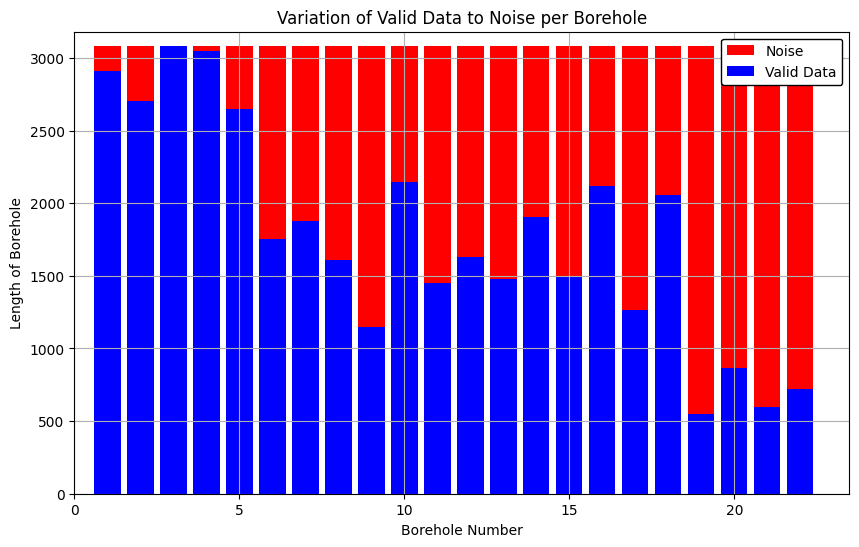

In [28]:
import matplotlib.pyplot as plt

All_len = []
for i in range(len(cleaned_qc_data)):
    temp_len = cleaned_qc_data[i]
    All_len.append(len(temp_len))
    
print(All_len)
print(type(All_len))

All_len_np = np.array(All_len)

x = np.arange(1,23,1)

total_length = 3081
noise = total_length - All_len_np

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, noise, bottom=All_len, label='Noise', color='red')
ax.bar(x, All_len, label='Valid Data', color='blue')


# Set y-axis limit to start from 0
ax.set_ylim(bottom=0, top=total_length+100)
ax.set_xlim(left=0)

# Adding labels and title
ax.set_xlabel('Borehole Number')
ax.set_ylabel('Length of Borehole')
ax.set_title('Variation of Valid Data to Noise per Borehole')
legend = ax.legend(frameon=True, edgecolor='black', framealpha=1.0)

# Show plot
ax.grid(True)

fig.savefig('Stage_5_Noise_to_Valid_Data_per_Borehole.png', dpi=300)
plt.show()

1c. More Noise Data Plot - Showing how useful data varies with depth

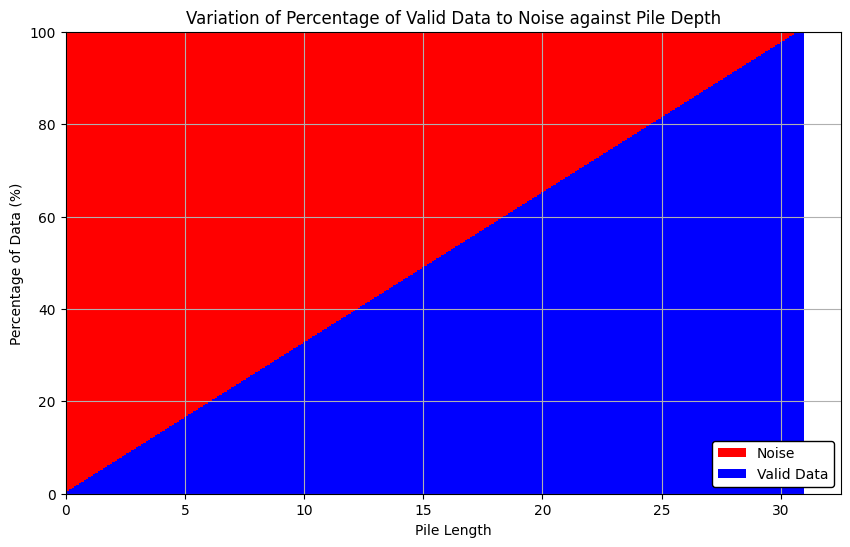

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Total data points and maximum length
total_data_points = 6162
max_length = 30.81

# Generate lengths and calculate corresponding useful data points
lengths = np.linspace(0, max_length, int(max_length * 10) + 1)  # Lengths from 0 to 30, with higher granularity
useful_data_points = (lengths / max_length) * total_data_points  # Convert lengths to useful data points

# Calculate percentage of useful data
percentage_useful = (useful_data_points / total_data_points) * 100
percentage_noise = 100 - percentage_useful  # Calculate percentage of noise

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data
ax.bar(lengths, percentage_noise, width=0.3, bottom=percentage_useful, label='Noise', color='red')  # Adding noise on top
ax.bar(lengths, percentage_useful, width=0.3, label='Valid Data', color='blue')  # Proper bar width


# Adding labels and title
ax.set_xlabel('Pile Length')
ax.set_ylabel('Percentage of Data (%)')
ax.set_title('Variation of Percentage of Valid Data to Noise against Pile Depth')
legend = ax.legend(frameon=True, edgecolor='black', framealpha=1.0)

# Set y-axis limit to start from 0
ax.set_ylim(bottom=0, top=100)  # Set the y-axis to percentage scale
ax.set_xlim(left=0)

# Show grid
ax.grid(True)

# Save the figure
fig.savefig('Stage_5_Percentage_Noise_to_Valid_Data_per_depth.png', dpi=300)
plt.show()


## 2. Calculating Effective Tip Resistance

In [30]:
BH_sets = 22

All_qc_eff = []

for i in range(BH_sets):
    temp_qc = cleaned_qc_data[i]
    temp_pwp = cleaned_pwp_data[i]

    All_qc_eff.append(eff_stress(temp_qc, temp_pwp))
    
print(len(All_qc_eff))
print(type(All_qc_eff[0]))

22
<class 'list'>


## 3. Remove first 200 points from each dataset 
Starting values are very likely to contain NaN values - replaced with zeros during preprocessing.
Additionally this is deep foundation analysis - hence pile length > 2 metres.

In [31]:
def remove_first_200_from_lists(nested_lists):
    modified_lists = []
    for lst in nested_lists:
        # If the sublist has at least 200 elements, slice after 200 and multiply each element by 1000
        if len(lst) >= 200:
            modified_sublist = [x * 1000 for x in lst[200:]]
            modified_lists.append(modified_sublist)
        else:
            # If the sublist has fewer than 200 elements, multiply each remaining element by 1000
            modified_sublist = [x * 1000 for x in lst]
            modified_lists.append(modified_sublist)
    return modified_lists


Cleaned_qc_eff = remove_first_200_from_lists(All_qc_eff)

print(len(Cleaned_qc_eff[2]))
print(type(Cleaned_qc_eff))

print([len(lst) for lst in Cleaned_qc_eff])

2881
<class 'list'>
[2709, 2506, 2881, 2849, 2451, 1554, 1678, 1412, 949, 1946, 1248, 1428, 1280, 1708, 1302, 1917, 1065, 1856, 348, 666, 400, 518]


## 4. Extracting Key Values - [mean, median, std_dev, range, skewness, kurtosis]

In [32]:
import numpy as np
from scipy.stats import skew, kurtosis

print(len(Cleaned_qc_eff))
print(len(Cleaned_qc_eff[1]))
print(type(Cleaned_qc_eff))

def extract_statistics_from_sublists(list_of_lists):
    results = []
    for sublist in list_of_lists:
        np_sublist = np.array(sublist)
        stats = [
            len(sublist),
            np.mean(np_sublist),
            np.median(np_sublist),
            np.std(np_sublist),
            np.ptp(np_sublist),
            skew(np_sublist),
            kurtosis(np_sublist)
            ]
        results.append(stats)
    return results


qc_eff_stats = extract_statistics_from_sublists(Cleaned_qc_eff)


print(len(qc_eff_stats))
print((qc_eff_stats[0]))
print(type(qc_eff_stats))

22
2506
<class 'list'>
22
[2709, 946.8789590254706, 885.7, 705.8567731076857, 14794.599999999999, 12.316463693027721, 209.68328427244805]
<class 'list'>


## 4b - Plotting a graph of the extracted features

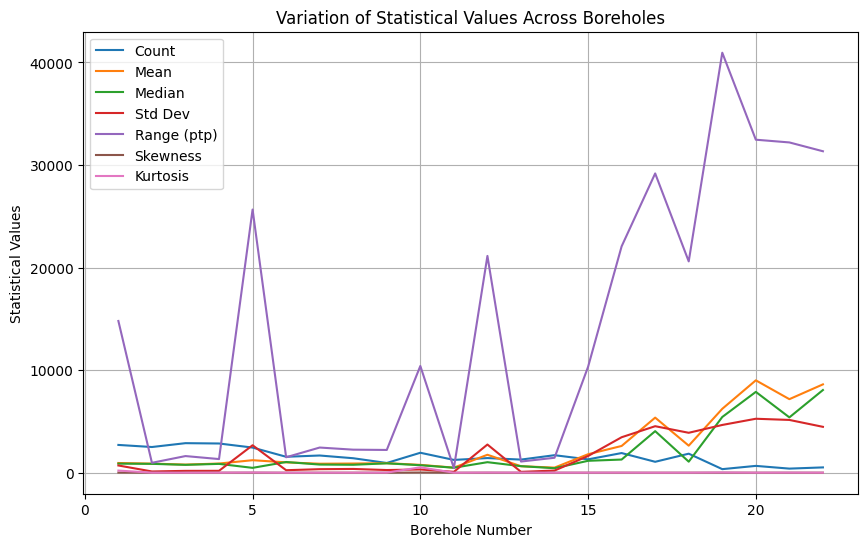

In [33]:
import matplotlib.pyplot as plt

# Assuming qc_eff_stats is already computed
qc_eff_stats = extract_statistics_from_sublists(Cleaned_qc_eff)

# Convert results to a numpy array for easier manipulation
stats_array = np.array(qc_eff_stats)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(1, stats_array.shape[0] + 1)  # Set numbers starting from 1

# Plot each statistic
ax.plot(x, stats_array[:, 0], label='Count')
ax.plot(x, stats_array[:, 1], label='Mean')
ax.plot(x, stats_array[:, 2], label='Median')
ax.plot(x, stats_array[:, 3], label='Std Dev')
ax.plot(x, stats_array[:, 4], label='Range (ptp)')
ax.plot(x, stats_array[:, 5], label='Skewness')
ax.plot(x, stats_array[:, 6], label='Kurtosis')

# Adding labels and title
ax.set_xlabel('Borehole Number')
ax.set_ylabel('Statistical Values')
ax.set_title('Variation of Statistical Values Across Boreholes')
ax.legend()

# Set grid
ax.grid(True)

# Save the figure before showing it
fig.savefig('Stage_5_Stat_Summary_of_BH.png', dpi=300)

# Show plot
plt.show()

## 5. Split data into Training, Validating and Testing Sets
Training = 16 Boreholes
Validating = 3 Boreholes
Testing = 3 Borheoles

In [34]:
Train_qc_eff = qc_eff_stats[:16]
Val_qc_eff = qc_eff_stats[16:19]
Test_qc_eff = qc_eff_stats[19:22]

## 6. Calculating Bearing Capacity Outputs using Eslami and Fellenuis (1997)

Must amend function - extending applicable range of skin_frict and base_cap to 2 more metres

Check that length of outputted capacities match the length of sets when imported in step 3 - after the first 200 values have been removed - this should allign. CRITICAL CHECK. 

In [35]:
## Just apply cleaned qc_eff data to equations

L = np.arange(2, 30.8, 0.1)
b = 0.4


All_cap = []
for i in range(len(Cleaned_qc_eff)):
    
    temp_qc_eff = Cleaned_qc_eff[i]
    print(len(temp_qc_eff))
    
    temp_cap =[]
    for length in L:
        print(length)
        print(len(temp_qc_eff)/100)
        if length*100 < (len(temp_qc_eff)+200) :
            temp_sf = skin_frict_calc(length, b, temp_qc_eff)
            
            temp_base = dense_base_cap_calc(length, b, temp_qc_eff)
            
            temp_cap.append((temp_sf + temp_base)/1000)
        else:
            pass
    All_cap.append(temp_cap)
    
print(qc_eff_stats[0])

2709
2.0
27.09
2.1
27.09
2.2
27.09
2.3000000000000003
27.09
2.4000000000000004
27.09
2.5000000000000004
27.09
2.6000000000000005
27.09
2.7000000000000006
27.09
2.8000000000000007
27.09
2.900000000000001
27.09
3.000000000000001
27.09
3.100000000000001
27.09
3.200000000000001
27.09
3.300000000000001
27.09
3.4000000000000012
27.09
3.5000000000000013
27.09
3.6000000000000014
27.09
3.7000000000000015
27.09
3.8000000000000016
27.09
3.9000000000000017
27.09
4.000000000000002
27.09
4.100000000000001
27.09
4.200000000000002
27.09
4.3000000000000025
27.09
4.400000000000002
27.09
4.500000000000002
27.09
4.600000000000002
27.09
4.700000000000003
27.09
4.8000000000000025
27.09
4.900000000000002
27.09
5.000000000000003
27.09
5.100000000000003
27.09
5.200000000000003
27.09
5.3000000000000025
27.09
5.400000000000003
27.09
5.5000000000000036
27.09
5.600000000000003
27.09
5.700000000000003
27.09
5.800000000000003
27.09
5.900000000000004
27.09
6.0000000000000036
27.09
6.100000000000003
27.09
6.2000000000

7. Creating applicable lengths list and checking data is correct length

In [36]:
print(len(All_cap[0]))

All_l = []
rows = 0
for i in range(22):
    temp_cap_len = All_cap[i]
    # print(len(temp_cap_len))
    rows = rows + len(temp_cap_len)
    temp_l = np.arange( 2, 2 + len(temp_cap_len)*0.1, 0.1)
    All_l.append(temp_l)
# print(All_l)
# print(len(All_l))
# print(All_l[-1])
# print(rows)

print(len(qc_eff_stats[0]))

271
7


## 8. Match length and bearing capacity combination with extracted key values from each CPTu

Note there is a small error here as temp_L[7] = 143 but temp_Cap[7] = 142 - these should be the same length. Made it work by just assigning based of temp_Cap - so technically 1 value is missed.

Very small margin of error - probably not an issue.

In [37]:
# Setup the columns for DataFrame
columns = ['Length']  + [f'CPTu_stats{i}' for i in range(1, 8)] + ['Bearing_Cap']

total_rows =  rows
data_array = np.empty((total_rows, len(columns)))

current_row = 0

for i in range(len(qc_eff_stats)):
    print(i)
    
    temp_L = All_l[i]
    temp_Cap = All_cap[i]
    
    print(len(temp_L), len(temp_Cap))
    
    for j in range(len(temp_Cap)):
        # Each row is Length + Flattened CPTU data + Output
        data_array[current_row, 0] = temp_L[j]
        data_array[current_row, 1:8] = qc_eff_stats[i] 
        data_array[current_row, 8] = temp_Cap[j]  # Make sure to check index if this is correct
        current_row += 1

# Create a DataFrame from the numpy array
df = pd.DataFrame(data_array, columns=columns)


0
271 271
1
251 251
2
288 288
3
285 285
4
246 246
5
156 156
6
168 168
7
143 142
8
95 95
9
195 195
10
125 125
11
143 143
12
128 128
13
171 171
14
131 131
15
193 192
16
107 107
17
186 186
18
35 35
19
67 67
20
40 40
21
52 52


9. Assigning Dataframe to Training, Validating and Testing sets

In [38]:
# Define the proportions
train_frac = 0.77
validate_frac = 0.115
test_frac = 0.115  # This should technically be (1 - train_frac - validate_frac)

# Shuffle the dataframe randomly
df = df.sample(frac=1).reset_index(drop=True)

# Calculate indices for splits
train_end = int(train_frac * len(df))
validate_end = train_end + int(validate_frac * len(df))

# Split the data
train_data = df[:train_end]
validate_data = df[train_end:validate_end]
test_data = df[validate_end:]

# train_data.to_csv('Stage_1_traind_stats_merged2.csv', index=False)
# validate_data.to_csv('Stage_1_vald_stats_merged2.csv', index=False)
# test_data.to_csv('Stage_1_testd_stats_merged2.csv', index=False)

print("CSV file has been created with the shape:", train_data.shape)
print("CSV file has been created with the shape:", validate_data.shape)
print("CSV file has been created with the shape:", test_data.shape)

CSV file has been created with the shape: (2674, 9)
CSV file has been created with the shape: (399, 9)
CSV file has been created with the shape: (401, 9)


10. Plotting Graph of new Training Data

<class 'list'>
22
16


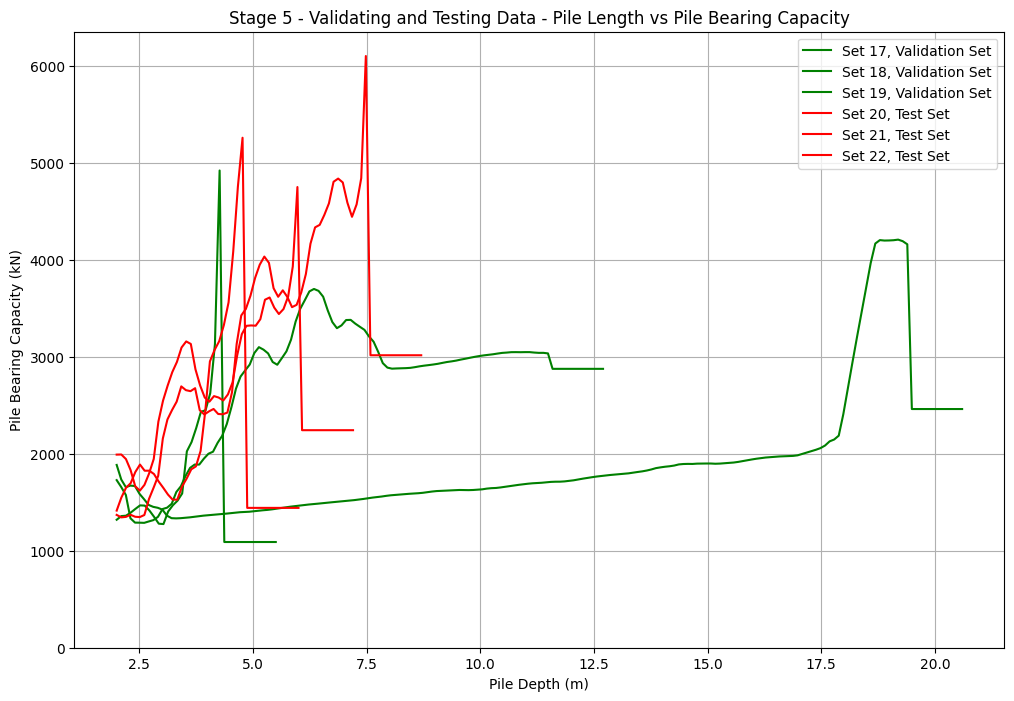

In [62]:
print(type(All_cap))
print(len(All_cap))
print(len(All_cap[:16]))



# Plot each dataset
plt.figure(figsize=(12, 8))
colors = ['green']*3 + ['red']*3   # First three red, next three green
set = ['Validation Set']*3 + ['Test Set']*3

for i, data in enumerate(All_cap[16:22]):
    # Calculate x-axis values based on the length of the data and scale by 100
    x_axis = np.linspace(2, 2 + len(data)/10, num=len(data))
    
    plt.plot(x_axis, data, label=f'Set {i+17}, {set[i]}', color=colors[i])

plt.xlabel('Pile Depth (m)')
plt.ylabel('Pile Bearing Capacity (kN)')
plt.ylim(bottom=0)
plt.title('Stage 5 - Validating and Testing Data - Pile Length vs Pile Bearing Capacity')
plt.legend()
plt.grid(True)
plt.savefig('Plot of Stage 5 - Validating and Testing Data - Pile Length vs Pile Bearing Capacity', dpi=300)

plt.show()
